In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [17]:
df = pd.read_csv('CSV_files/shark_clean.csv')

In [18]:
df.head()

,Unnamed: 0,Date,Year,Type,Country,Area,Location,Activity,Sex,Injury,Fatal (Y/N),Time,Species
0,0,09-Oct-2020,2020.0,Unprovoked,AUSTRALIA,Western Australia,Kelp Beds Beach (Kelpies),Surfing,M,Fatal,Y,10h45,Not Available
1,1,07-Oct-2020,2020.0,Unprovoked,USA,Florida,"Miami Beach, Miami-Dade County",Body Surfing,M,Survived,N,Afternoon,Blacktip shark
2,2,04-Oct-2020,2020.0,Unprovoked,AUSTRALIA,Western Australia,"Toms Surf break, Hamersley Pool, North Beach, ...",Surfing,M,No Injury,N,10h45,Bronze whaler 1.5m
3,4,20-Sep-2020,2020.0,Unprovoked,USA,Florida,"Sombero Key Light, Monroe County",Snorkeling,M,Survived,N,10h30,Bull shark
4,5,17-Sep-2020,2020.0,Provoked,AUSTRALIA,Queensland,Fraser Island,Fishing,M,Survived,N,16h00,"""whitetip shark"""


In [19]:
df.drop(['Unnamed: 0', 'Area', 'Fatal (Y/N)', 'Location', 'Time'], axis=1, inplace=True)

In [20]:
for i in df:
    print(i, '/n')
    
    print(df[i].value_counts(normalize=True).head())
    print('-----------------')

Date /n
1957    0.001528
1941    0.001189
1942    0.001189
1950    0.001189
1958    0.001189
Name: Date, dtype: float64
-----------------
Year /n
2015.0    0.022075
2017.0    0.021056
2016.0    0.020207
0.0       0.020207
2011.0    0.020037
Name: Year, dtype: float64
-----------------
Type /n
Unprovoked      0.797928
Provoked        0.099677
Watercraft      0.056546
Sea Disaster    0.038377
Invalid         0.004245
Name: Type, dtype: float64
-----------------
Country /n
USA                 0.365597
AUSTRALIA           0.213619
SOUTH AFRICA        0.088130
PAPUA NEW GUINEA    0.022075
NEW ZEALAND         0.021056
Name: Country, dtype: float64
-----------------
Activity /n
Surfing          0.169808
Swimming         0.134318
Fishing          0.074206
Not Available    0.065716
Spearfishing     0.055357
Name: Activity, dtype: float64
-----------------
Sex /n
M    0.886059
F    0.113941
Name: Sex, dtype: float64
-----------------
Injury /n
Survived     0.671761
Fatal        0.211411
No Injur

# Creating Categoricals

## Date Categoricals

In [21]:
df['Year'] = [i[-4:] for i in df['Date']]

In [22]:
for i, d in enumerate(df['Year']):
    try:
        df['Year'][i] = int(d)
    except:
        df['Year'][i] = 0

In [23]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [24]:
df['Month'] = 'NA'

In [25]:
for i, d in enumerate(df['Date']):
    for m in months:
        if d.find(m) != -1:
            s = d.find(m)
            df['Month'][i] = d[s:s+3]

In [26]:
m = pd.get_dummies(df['Month'])

In [27]:
df = pd.concat([df,m], axis=1)
df.drop(['Date', 'NA', 'Month'], axis=1, inplace=True)

## Type categoricals

In [28]:
def make_dummy(col):
    top_4_values = df[col].value_counts()[:4]
    other_values = df[col].value_counts()[4:]
    
    for name in top_4_values.keys():
        df.loc[df[col] == name, f'{col}: {name}'] =1
        
    for name in other_values.keys():
        df.loc[df[col] == name, f'{col}: other'] =1
    
    df.drop(col, axis=1, inplace=True)

In [29]:
make_dummy('Type')

## Other Categoricals 

In [1]:
categoricals = ['Country', 'Activity', 'Sex', 'Species ']
for i in categoricals:
        make_dummy(i)

NameError: name 'make_dummy' is not defined

In [2]:
 df.fillna(0, inplace=True)

NameError: name 'df' is not defined

In [32]:
 df.to_csv('CSV_files/shark_model.csv')

# Model

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('CSV_files/shark_model.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [2]:
X = df.drop(['Injury'], axis = 1)
y = df['Injury']

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [4]:
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()


X_train_minmax = mmscaler.fit_transform(X_train)
X_test_minmax = mmscaler.transform(X_test)

## Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, C=1e12, multi_class = 'multinomial', solver='lbfgs')
model_log = logreg.fit(X_train_minmax, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False,
                   multi_class='multinomial')

In [6]:
y_hat_test = model_log.predict(X_test_minmax)
y_hat_train = model_log.predict(X_train_minmax)

In [7]:
from sklearn.metrics import roc_auc_score

y_score = model_log.fit(X_train_minmax, y_train).predict_proba(X_test_minmax)

auc = roc_auc_score(y_test, y_score, multi_class = 'ovo')

In [8]:
from sklearn.metrics import classification_report

print('Test data')
print(classification_report(y_test, y_hat_test))
print(f'AUC: {auc}')

Test data
              precision    recall  f1-score   support

       Fatal       0.47      0.28      0.35       318
   No Injury       0.80      0.35      0.48       196
    Survived       0.71      0.89      0.79       959

    accuracy                           0.68      1473
   macro avg       0.66      0.50      0.54      1473
weighted avg       0.67      0.68      0.65      1473

AUC: 0.7882071913766261


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


plot_confusion_matrix(logreg, X_test, y_test,
                     cmap=plt.cm.Blues)

In [10]:
y_test.value_counts()

Survived     959
Fatal        318
No Injury    196
Name: Injury, dtype: int64

### Smote


In [11]:
from imblearn.over_sampling import SMOTE

In [12]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_minmax, y_train)

In [13]:
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2, 1e13]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2, 1e13]

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, multi_class = 'multinomial', solver='lbfgs')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = model_log.predict(X_test_minmax)

    y_score = model_log.fit(X_train_resampled, y_train_resampled).predict_proba(X_test_minmax)

    auc = roc_auc_score(y_test, y_score, multi_class = 'ovo')
    
    print(f'AUC for {names[n]}: {auc}')
    print('-------------------------------------------------------')

LogisticRegression(C=0.005, fit_intercept=False, multi_class='multinomial')
AUC for 0.005: 0.7870831386508866
-------------------------------------------------------
LogisticRegression(C=0.1, fit_intercept=False, multi_class='multinomial')
AUC for 0.1: 0.7912931200706751
-------------------------------------------------------
LogisticRegression(C=0.2, fit_intercept=False, multi_class='multinomial')
AUC for 0.2: 0.7907057769035303
-------------------------------------------------------
LogisticRegression(C=0.5, fit_intercept=False, multi_class='multinomial')
AUC for 0.5: 0.7898555984916511
-------------------------------------------------------
LogisticRegression(C=0.8, fit_intercept=False, multi_class='multinomial')
AUC for 0.8: 0.7894647780807484
-------------------------------------------------------
LogisticRegression(C=1, fit_intercept=False, multi_class='multinomial')
AUC for 1: 0.78932886843
-------------------------------------------------------
LogisticRegression(C=1.25, fit_in

In [14]:
logreg = LogisticRegression(fit_intercept=False, C=0.1, multi_class = 'multinomial', solver='lbfgs')
model_log = logreg.fit(X_train_resampled, y_train_resampled)
y_hat_test = model_log.predict(X_test_minmax)

In [15]:
print('Test data')
print(classification_report(y_test, y_hat_test))
print(f'AUC: {auc}')

Test data
              precision    recall  f1-score   support

       Fatal       0.41      0.73      0.53       318
   No Injury       0.37      0.57      0.44       196
    Survived       0.80      0.51      0.63       959

    accuracy                           0.57      1473
   macro avg       0.53      0.60      0.53      1473
weighted avg       0.66      0.57      0.58      1473

AUC: 0.7875317336291747


## Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier 
clf = DecisionTreeClassifier(criterion='entropy')

model_clf = clf.fit(X_train_minmax, y_train)

y_pred = model_clf.predict(X_test_minmax)

In [17]:
from sklearn.metrics import accuracy_score, roc_curve, auc

# Look at the classification report
print('\n',classification_report(y_test, y_pred))

# Check the AUC for predictions
y_score = model_clf.fit(X_train_minmax, y_train).predict_proba(X_test_minmax)
auc = roc_auc_score(y_test, y_score, multi_class = 'ovo')
print(f'\nAUC is :{auc}')


               precision    recall  f1-score   support

       Fatal       0.43      0.44      0.43       318
   No Injury       0.46      0.40      0.43       196
    Survived       0.73      0.75      0.74       959

    accuracy                           0.63      1473
   macro avg       0.54      0.53      0.53      1473
weighted avg       0.63      0.63      0.63      1473


AUC is :0.6444168916640312


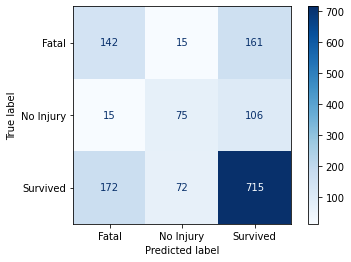

In [18]:
plot_confusion_matrix(model_clf, X_test_minmax, y_test,
                     cmap=plt.cm.Blues);

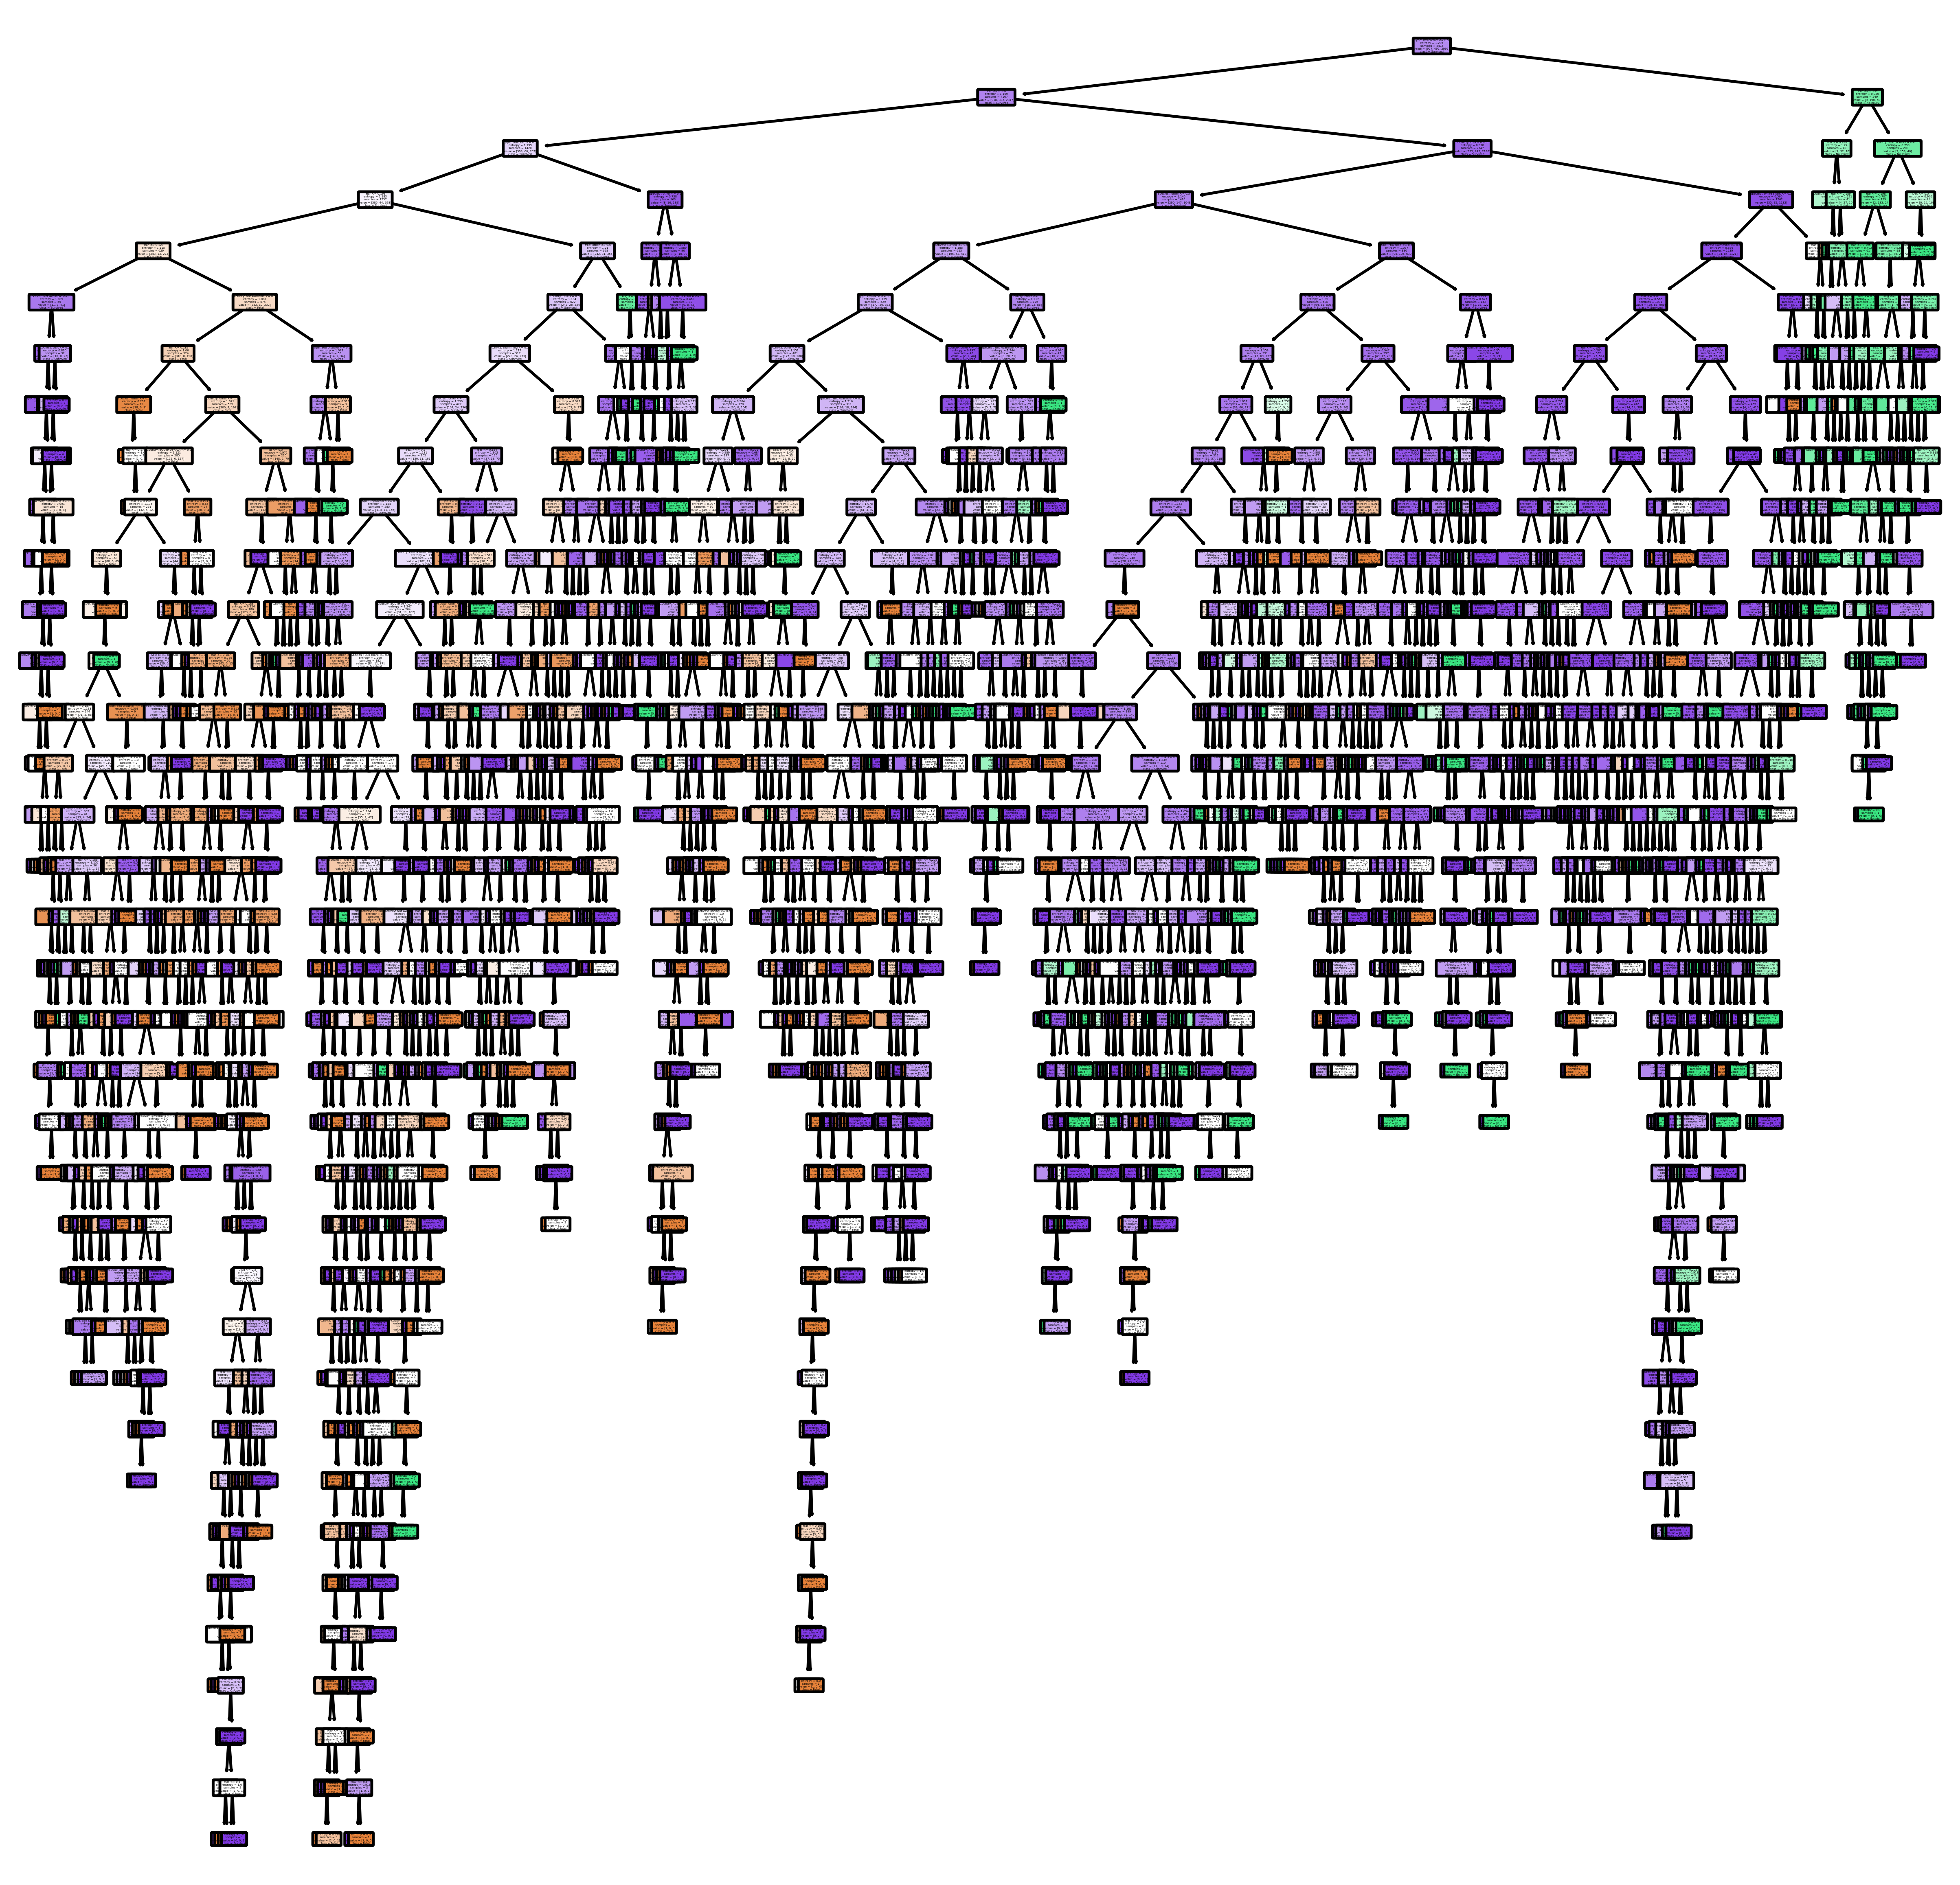

In [26]:
from sklearn import tree

plt.figure(figsize=(12,12), dpi=500)
tree.plot_tree(clf, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

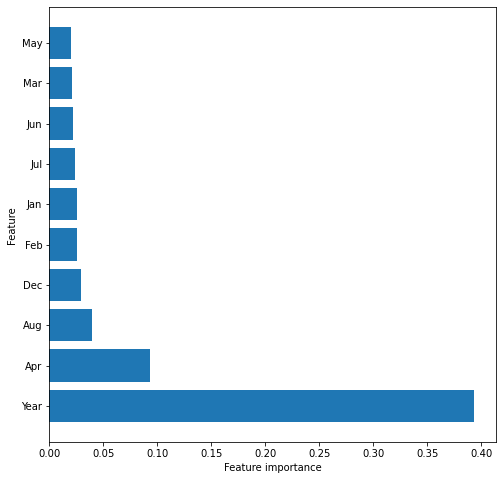

In [19]:
def plot_feature_importances(model):
    n_features = 10
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), np.sort(clf.feature_importances_)[:-11:-1], align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(clf)

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, max_depth= 10)
model_forest = forest.fit(X_train_minmax, y_train)

In [22]:
y_pred = model_forest.predict(X_test_minmax)
print(classification_report(y_test, y_pred))

# Check the AUC for predictions
y_score = model_forest.fit(X_train_minmax, y_train).predict_proba(X_test_minmax)
roc_auc = roc_auc_score(y_test, y_score, multi_class = 'ovo')
print(f'\nAUC is :{auc}')

              precision    recall  f1-score   support

       Fatal       0.54      0.27      0.36       318
   No Injury       0.82      0.34      0.48       196
    Survived       0.71      0.91      0.80       959

    accuracy                           0.70      1473
   macro avg       0.69      0.51      0.55      1473
weighted avg       0.69      0.70      0.66      1473


AUC is :0.6444168916640312
